<a href="https://colab.research.google.com/github/BhoomiMahna/outfit-vibe-rater/blob/main/fit_tightness_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded= files.upload()


Saving outfits_final.zip to outfits_final.zip


In [2]:
import os
import zipfile
zip_path = "outfits_final.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref: zip_ref.extractall()

print("folders after extraction", os.listdir())

fit_path = os.path.join("outfits", "fit tightness")
print("classes in fit tightness", os.listdir(fit_path))


folders after extraction ['.config', 'outfits', 'outfits_final.zip', 'sample_data']
classes in fit tightness ['tight dress solid single layer (30).jpg', 'tight dress solid.jpg', 'tight dress solid single layer (37).jpg', 'tight dress solid single layer (34).jpg', 'tight dress solid single layer (25).jpg', 'tight dress solid single layer (39).jpg', 'tight dress solid single layer (55).jpg', 'tight dress solid single layer (20).jpg', 'tight dress solid single layer (29).jpg', 'tight dress solid single layer (35).jpg', 'tight dress solid single layer (62).jpg', 'tight dress solid single layer (28).jpg', 'tight dress solid single layer (24).jpg', 'tight dress solid single layer (1).jpg', 'tight dress solid single layer (2).jpg', 'tight dress solid single layer (41).jpg', 'tight dress solid single layer (26).jpg', 'tight dress solid single layer (51).jpg', 'tight dress solid single layer (31).jpg', 'tight dress solid single layer (38).jpg', 'tight dress solid single layer (10).jpg', 'tight 

In [3]:
from pathlib import Path
fit_path= Path("outfits/fit tightness")

for class_folder in fit_path.iterdir():
  if class_folder.is_dir():
    count = sum(1 for f in class_folder.iterdir() if f.is_file())
    print(f"{class_folder.name}: {count} images")

total_images = sum(1 for f in fit_path.rglob("*") if f.is_file())
print("total images in fit tightness", total_images)

tight: 524 images
baggy: 360 images
total images in fit tightness 949


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,models

img_size = (128,128)
batch_size = 32
#fit_path= "outfits/fit tightness"

train_ds = tf.keras.utils.image_dataset_from_directory( fit_path, image_size=img_size, batch_size=batch_size,
                                                       label_mode='categorical', validation_split=0.2, subset='training', seed=42)

class_names = train_ds.class_names
num_classes=len(class_names)
print(f"Class names found: {class_names}")

val_ds = tf.keras.utils.image_dataset_from_directory( fit_path, image_size=img_size, batch_size=batch_size,
                                                       label_mode='categorical', validation_split=0.2, subset='validation', seed=42)


normalization_layer = tf.keras.layers.Rescaling(1./255)

data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
], name="data_augmentation"
)

train_ds= train_ds.map(lambda x,y:(normalization_layer(x),y))
val_ds= val_ds.map(lambda x,y:(normalization_layer(x),y))

Found 884 files belonging to 2 classes.
Using 708 files for training.
Class names found: ['baggy', 'tight']
Found 884 files belonging to 2 classes.
Using 176 files for validation.


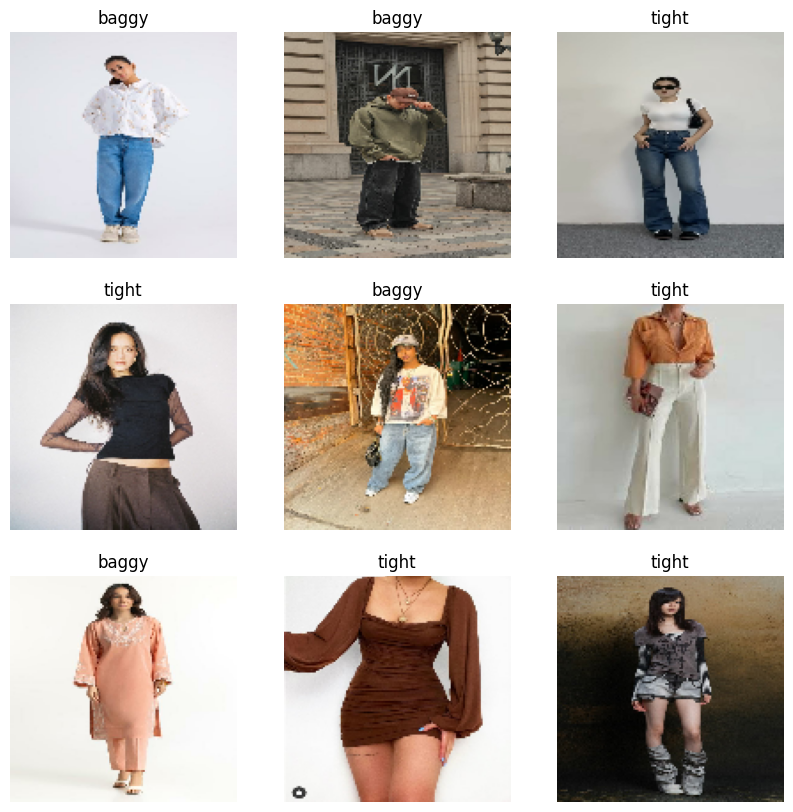

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(10,10))

for images,labels in train_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy())
    label_index = np.argmax(labels[i])
    plt.title(class_names[label_index])
    plt.axis("off")

plt.show()

In [7]:
train_ds=train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


data_dir = 'outfits/fit tightness'
img_size = (260, 260)
batch_size = 32


print("Loading and preparing datasets...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Found classes: {class_names}")


data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
], name="data_augmentation")


AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


base_model = tf.keras.applications.EfficientNetV2B2(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet'
)


base_model.trainable = False


inputs = layers.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)


initial_epochs = 10
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Starting Initial Training ---")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs
)


base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Starting Fine-Tuning ---")
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]
)


final_loss, final_accuracy = model.evaluate(val_ds)
print(f"\nFinal Validation Accuracy with EfficientNetV2B2: {final_accuracy:.4f}")

Loading and preparing datasets...
Found 884 files belonging to 2 classes.
Using 708 files for training.
Found 884 files belonging to 2 classes.
Using 176 files for validation.
Found classes: ['baggy', 'tight']
35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Starting Initial Training ---
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.5819 - loss: 0.6981 - val_accuracy: 0.7727 - val_loss: 0.4862
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 102s 5s/step - accuracy: 0.7331 - loss: 0.5168 - val_accuracy: 0.8239 - val_loss: 0.4043
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.7930 - loss: 0.4442 - val_accuracy: 0.8239 - val_loss: 0.3799
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.7899 - loss: 0.4367 - val_accuracy: 0.8352 - val_loss: 0.3567
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.8203 - loss: 0.4082 - val_accuracy: 0.8409 - val_loss: 0.3471
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.8052